# Example Angle Comparison

At times it may be useful to confirm that the spatial transform solution returned by PINK is sensible. In this notebook we perform our derivation of the spatial transform for an image to its corresponding best matching neuron.

In [1]:
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import numpy as np
from tqdm import tqdm
from scipy.ndimage import rotate

import pyink as pu


## Datasets

A set of SOMs were trained against ~24,000 images with images from EMU and WISE W1 surveys. The input image size was 5 arcminutes. Below are the base file names that will be used to load in:
- preprocessed training images provided to PINK
- the SOM, mapping and spatial transform data files produced by PINK

The `PathHelper` is a simple utility class to help make folders and sub-folders without to much difficulty. 


In [2]:
path = pu.PathHelper('Example_Images', clobber=True)
suffix = 'B3Circular_h45_w45_emu.bin'

som = pu.SOM(f'../../EMU_WISE_E95E05_Aegean_Components_Complex_EMUWISE_IslandNorm_Log_Reprojected/SOMs/SOM_{suffix}')
transform = pu.Transform(f'../../EMU_WISE_E95E05_Aegean_Components_Complex_EMUWISE_IslandNorm_Log_Reprojected/SOMs/TRANSFORM_{suffix}')
mapper = pu.Mapping(f'../../EMU_WISE_E95E05_Aegean_Components_Complex_EMUWISE_IslandNorm_Log_Reprojected/SOMs/MAP_{suffix}')

image_binary = '../../EMU_WISE_E95E05_Aegean_Components_Complex_EMUWISE_IslandNorm_Log_Reprojected/EMU_WISE_E95E05_Aegean_Components_Complex_EMUWISE_IslandNorm_Log_Reprojected.bin'
imgs = pu.ImageReader(image_binary)


Note that the number of valid pixels in each of the masks is the same. This has to be done to ensure a correct pixelwise euclidean distance summation. At the moment a radius of 75 produces an inconsistent number of valid pixels. This is being looked into and is likely a rounding error (if you spot it please let me know :) )

Valid number of pixels:  17193 17193


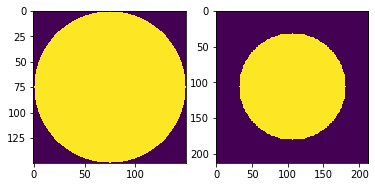

In [3]:
src_img = imgs.data[1, 0]
bmu_min = mapper.bmu(1)
bmu_img = som[bmu_min][0]

src_mask = pu.circular_mask(src_img, radius=74)
bmu_mask = pu.circular_mask(bmu_img, radius=74)

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.imshow(src_mask)
ax2.imshow(bmu_mask)

print('Valid number of pixels: ', np.sum(src_mask), np.sum(bmu_mask))

# Angle distribution

The spatial transforms return by `PINK` should be, essentially, random. Here a few quick tests are performed to ensure that they behave as expected. This includes manually finding the optimal spatial transform solution between a given image a neuron to see if it agrees with the solution found by `PINK`. 

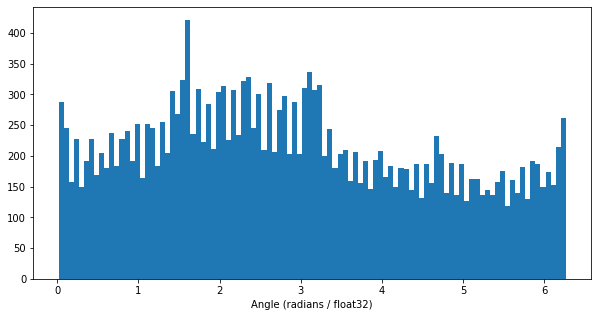

In [4]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
bmus = mapper.bmu()[:]

datas = transform.data[:][np.arange(transform.data.shape[0]), bmus[:, 0], bmus[:, 1]]

ax.hist(datas['angle'].flatten(), bins=100)
ax.set(xlabel='Angle (radians / float32)')

fig.savefig(f'{path}/Angles.png')

In [5]:
def pink_rotation(src, angle):
    """A pure python translation of the C++ code used by PINK. 
    """
    width_margin = 0
    height_margin = 0

    rot = np.zeros_like(src)
    
    x0 = src.shape[1] // 2
    y0 = src.shape[0] // 2

    cos_alpha = np.cos(angle)
    sin_alpha = np.sin(angle)

    for x2 in range(src.shape[1]):
        for y2 in range(src.shape[0]):
            x1 = (x2 + width_margin - x0) * cos_alpha + (y2 + height_margin - y0) * sin_alpha + x0 + 0.1
            if x1 < 0 or int(x1) >= src.shape[1]:
                rot[y2, x2] = 0
                continue

            y1 = (y2 + height_margin - y0) * cos_alpha - (x2 + width_margin - x0) * sin_alpha + y0 + 0.1
            if y1 < 0 or int(y1) >= src.shape[0]:
                rot[y2, x2] = 0
                continue

            ix1 = int(x1)
            iy1 = int(y1)
            ix1b = int(ix1 + 1)
            iy1b = int(iy1 + 1)
            rx1 = int(x1 - ix1)
            ry1 = int(y1 - iy1)
            cx1 = int(1. - rx1)
            cy1 = int(1. - ry1)

            if max(iy1, ix1, iy1b, ix1b) >= 150:
                continue

            rot[y2, x2] = cx1 * cy1 * src[iy1, ix1] +\
                          cx1 * ry1 * src[iy1b, ix1] +\
                          rx1 * cy1 * src[iy1, ix1b] +\
                          rx1 * ry1 * src[iy1b, ix1b]
            
    return rot

In [6]:
def euclidean_dist(img_a, img_b):
    return np.sum((img_a - img_b)**2.)

def manual_transform(img_idx, imgs, mapper, transform, som, rot_axes=(1,0),
                     pink_rotate=False, verbose=True, plot=True):
    """Given a best matching neuron and an image, compute the best matching spatial transform outside of PINK.
    """
    
    src_img = imgs.data[img_idx, 0]
    bmu_img = som[bmu_min][0]
    bmu_trans = transform.data[(img_idx, *bmu_min)]
    bmu_ed   = mapper.data[(img_idx, *bmu_min)]

    src_mask = pu.square_mask(src_img, 105)
    bmu_mask = pu.square_mask(bmu_img, 105)
    src_mask = pu.circular_mask(src_img, radius=74)
    bmu_mask = pu.circular_mask(bmu_img, radius=74)
    
    no_rots = 360
    do_flip = True
    residuals = np.zeros(no_rots * (do_flip+1))
    radian_step = 2*np.pi / no_rots
    
    offset = no_rots // 4
    
    for i in range(offset):
        ang = radian_step * i
        
        if pink_rotate:
            rot_img = pink_rotation(src_img, ang)
        else:
            rot_img = rotate(src_img, -np.rad2deg(ang), reshape=False, order=1)

        residuals[i] = euclidean_dist(rot_img[src_mask], bmu_img[bmu_mask])        
        
        rot_img_90 = np.rot90(rot_img, axes=rot_axes)
        residuals[i+offset] = euclidean_dist(rot_img_90[src_mask], bmu_img[bmu_mask])
        
        rot_img_180 = np.rot90(rot_img_90, axes=rot_axes)
        residuals[i+(2*offset)] = euclidean_dist(rot_img_180[src_mask], bmu_img[bmu_mask])
        
        rot_img_270 = np.rot90(rot_img_180, axes=rot_axes)
        residuals[i+(3*offset)] = euclidean_dist(rot_img_270[src_mask], bmu_img[bmu_mask])
            
        if do_flip:
            flip_img = rot_img[::-1]
            residuals[i+no_rots] = euclidean_dist(flip_img[src_mask], bmu_img[bmu_mask])
            
            flip_img_90 = rot_img_90[::-1]
            residuals[i+offset+no_rots] = euclidean_dist(flip_img_90[src_mask], bmu_img[bmu_mask])
            
            flip_img_180 = rot_img_180[::-1]
            residuals[i+(2*offset)+no_rots] = euclidean_dist(flip_img_180[src_mask], bmu_img[bmu_mask])
            
            flip_img_270 = rot_img_270[::-1]
            residuals[i+(3*offset)+no_rots] = euclidean_dist(flip_img_270[src_mask], bmu_img[bmu_mask])
            
    arg_min = np.argmin(residuals)

    flip = arg_min // 360
    rot = (arg_min % no_rots) * radian_step
    
    if verbose:
        print(img_idx)
        print("\tManual:", flip, rot)
        print("\tPINK  :", bmu_trans)
        print("\tDiff  :", flip - bmu_trans[0], rot - bmu_trans[1])

    if plot:
        fig, ax = plt.subplots(1,1)

        idx = np.arange(no_rots)
        ax.plot(idx * radian_step, residuals[idx], 'r-', label='No flip')

        if do_flip:
            idx = np.arange(no_rots, 2*no_rots)
            ax.plot((idx-no_rots)*radian_step, residuals[idx], 'g:', label='With flip')

        if flip:
            ax.axvline(rot, ls=':', color='green', label='Manual Minimised ED Position')
        else:
            ax.axvline(rot, ls='-', color='red', label='Manual Minimised ED Position')

        if bmu_trans[0] == 1:
            ax.axvline(bmu_trans[1], ls=':', lw=5, color='Pink', label='PINK Minimised ED Position')
        else:
            ax.axvline(bmu_trans[1], ls='-', lw=5, color='Pink', label='PINK Minimised ED Position')


        ax.legend(loc='upper right')
        ax.set(xlabel="Angle (Radian)", ylabel="Residual")

        fig.show()

    cp_img = src_img.copy()
    cp_img = rotate(cp_img, -np.rad2deg(rot), reshape=False)

    if flip:
        cp_img = cp_img[::-1, :]

    pink_img = src_img.copy()
    pink_img = rotate(pink_img, -np.rad2deg(bmu_trans[1]), reshape=False, order=2)

    if bmu_trans[0] == 1:
        pink_img = pink_img[::-1, :]

        
    if plot:
        fig, ax = plt.subplots(1,3, figsize=(15, 4))

        ax[0].imshow(cp_img)
        ax[0].set(title='Manual Transform')
        ax[0].grid(which='major', axis='both')

        
        ax[1].imshow(bmu_img[31:-31, 31:-31])
        ax[1].set(title='BMU')
        ax[1].grid(which='major', axis='both')

        ax[2].imshow(pink_img)
        ax[2].set(title='PINK Transform')
        ax[2].grid(which='major', axis='both')

        
        fig.show()
    
    return flip, rot, rot - bmu_trans[1], bmu_trans[0], bmu_trans[1], bmu_ed


In [7]:
def manual_transform_lambda(i):
    return manual_transform(i, imgs, mapper, transform, som, verbose=False, plot=False)

samples = 1000
workers = 8
with ProcessPoolExecutor(max_workers=workers) as executor:
    results = list(tqdm(executor.map(manual_transform_lambda, np.arange(samples), chunksize=samples//workers//4), total=samples))


100%|██████████| 1000/1000 [00:48<00:00, 20.51it/s] 


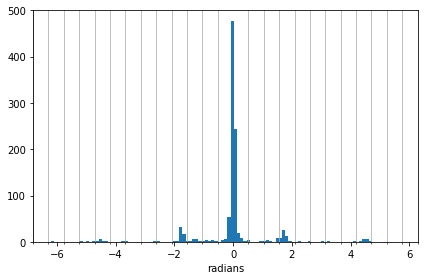

In [8]:
res = np.array(results)

fig, ax = plt.subplots(1,1)

ax.hist(res[:,2], bins=100)

tick_lines = np.deg2rad(30)*np.arange(-13, 13)
ax.set_xticks(tick_lines, minor=True)
ax.grid(True, axis='both', which='minor')
ax.set_xlabel('radians')

fig.tight_layout()
fig.savefig(f"{path}/residual_angle.png")

The spatial transform solutions derived between PINK and the python code for almost all sources should agree on a 1-to-1 level. You may notice that there are a set of sources that fall off this 1-to-1 one line. This can be tested below. 

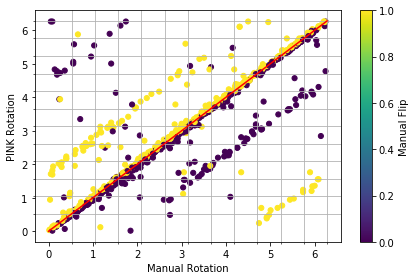

In [9]:
res = np.array(results)

fig, ax = plt.subplots(1,1)

cim = ax.scatter(res[:, 1], res[:, 4], c=res[:,0], s=26)

ax.set(xlabel='Manual Rotation', ylabel='PINK Rotation')

tick_lines = np.deg2rad(30)*np.arange(-1, 13)
ax.set_xticks(tick_lines, minor=True)
ax.set_yticks(tick_lines, minor=True)

ax.grid(True, axis='both', which='minor')

one = np.linspace(0, 2*np.pi)
ax.plot(one, one, 'r-')

fig.colorbar(cim, label='Manual Flip')

fig.tight_layout()
fig.savefig(f'{path}/Manual_PINK_Angle.png')

You may also notice that this are largely consistent with whether an image was flipped or not flipped. Generally for these sources the euclidean distances are approximately the same between two competing spatial transform solutions, and what determines the minimum is influenced by numerical precision errors. 

/Users/gal16b/miniconda3/envs/emu_som/lib/python3.7/site-packages/ipykernel_launcher.py:93: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/gal16b/miniconda3/envs/emu_som/lib/python3.7/site-packages/ipykernel_launcher.py:125: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


(1, 5.445427266222308, 4.502949503523181, 0, 0.94247776, 6.1729627)

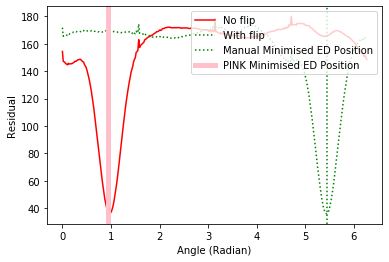

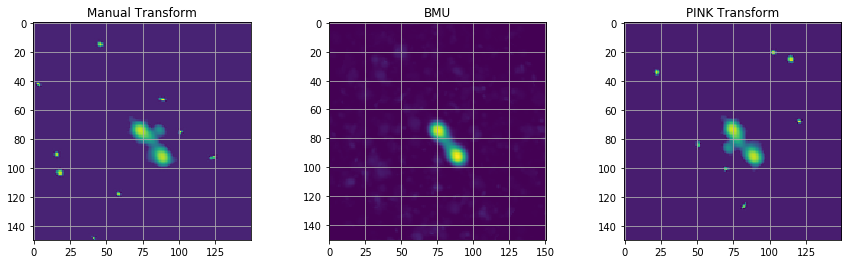

In [10]:
outlier = np.argwhere(np.abs(res[:,1] - res[:,4]) > np.pi )

manual_transform(outlier[0][0], imgs, mapper, transform, som, verbose=False, plot=True)
